# Sensors, Perception and Actuation
## Assignment - 4


### Github Link: https://github.com/syedjameel/SPA-Assignment-4.git

Student : Jameel Ahmed Syed
email : j.syed@innopolis.university

### Task 1
Generate a noisy dataset with a line and detet the line using RANSAC algorithm
actuation
- Generate a 2D dataset with a noisy line (using e.g. Gauss noise or a noise of another distribution)
- Create a code in Python (or use an existing library) that detects the line parameters (e.g., a and b coefficients of y = ax + b line model) using RANSAC algorithm
- Visualize the RANSAC-based line detection

### Task 2
Detect & visualize an object from 3D point cloud by eliminating the environment,
and estimate the distance to the object (the minimal depth measurement)
- Record (Download or Generate) indoor 3D sensor dataset in a room environment with an object (tips: you can measure a real 3D Kinect/3D LIDAR dataset at the robotics lab, or find a 3D Kinect/3D LIDAR dataset in the Internet, or Simulate your own dataset in a Robotic Simulator, e.g. Gazebo/ROS, Webots, CoppeliaSim, or just model the noisy 3D point cloud indoor environment with an object in Python)
- Detect & Remove the redundant 3D point clouds that belong to environment (e.g. by filtering the depth with setting the reasonable thresholds on minimal and maximal range)
- Detect & Remove the redundant 3D point clouds that belong to a floor (using a plane detector based on RANSAC)
- Mark the object in the 3D point cloud (changing the object’s color), and estimate the distance to the object (the minimal depth)


# Task - 1

### 1. Import All the Necessary Libraries


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import ransac, LineModelND
import random
from sklearn.neighbors import KDTree

### 2. Generate a 2D dataset with a noisy line (using e.g. Gauss noise or a noise of another distribution)

a) First generate a 1D dataset

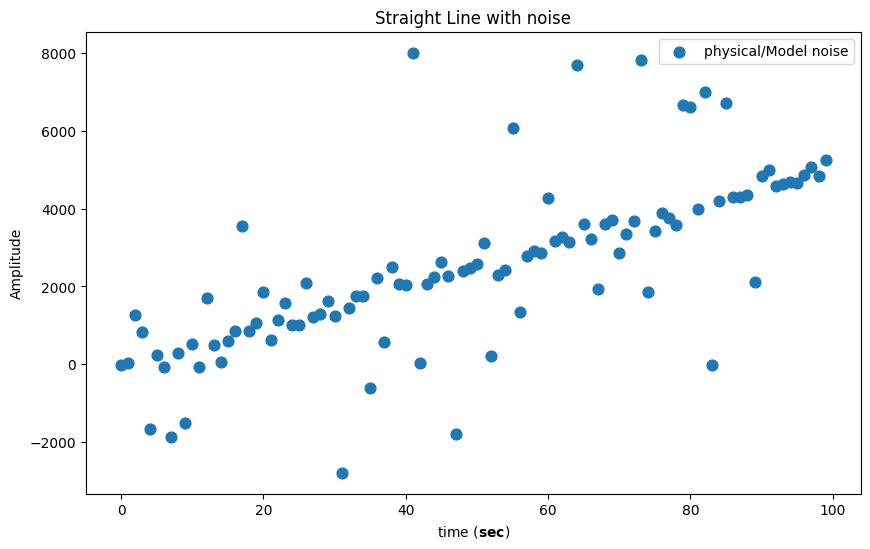

In [72]:
# Generate the straight line with random gaussian noise
m = 50  # Slope of the straight line
c = 1   # y-intercept of the straight line
N = 100     # number of samples

x = np.arange(N)    # Create a range of N samples

# Create a line y = m*x + c + random normal distribution noise
y = m*x + c + 10*np.random.normal(0, 20, N)

# Make the random points in the line to shift by random normal distribution noise
random_indices = np.random.randint(len(y) , size = np.abs(int(np.random.normal(0,len(y)))))
for i in random_indices:
    y[i] += 20*np.random.normal(0,100)

# Plot
plt.figure(figsize=(10, 6))
plt.title("Straight Line with noise")
plt.xlabel("time $(\mathbf{sec})$")
plt.ylabel("Amplitude")
plt.scatter(x, y, label="physical/Model noise", marker="o", s=60)
plt.legend()
plt.show()
#plt.savefig('straight-line-with-noise.png')

### 3. Create a code in Python (or use an existing library) that detects the line parameters (e.g., a and b coefficients of y = ax + b line model) using RANSAC algorithm

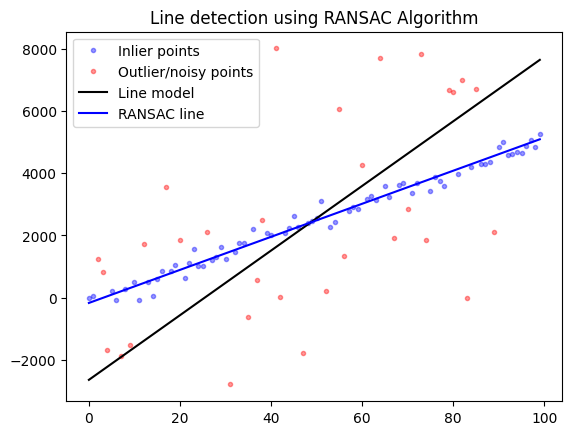

In [73]:
# Reference: https://scikit-image.org/docs/dev/auto_examples/transform/plot_ransac.html

# Stack the x and y data
data = np.column_stack([x, y])

# Fit the data to a simple Line using least-square method for N-dimensional lines
model = LineModelND()
model.estimate(data)

# Fit the line from the noisy data using RANSAC algorithm
model_robust, inliers = ransac(data, LineModelND, min_samples=2,
                               residual_threshold=10, max_trials=1000)
outliers = inliers == False

# Get the estimated values
line_x = np.arange(N)
line_y = model.predict_y(line_x)
line_y_robust = model_robust.predict_y(line_x)


# Plot
fig, ax = plt.subplots()
plt.title("Line detection using RANSAC Algorithm")
ax.plot(data[inliers, 0],
        data[inliers, 1],
        '.b',
        alpha=0.4,
        label='Inlier points')
ax.plot(data[outliers, 0],
        data[outliers, 1],
        '.r',
        alpha=0.4,
        label='Outlier/noisy points')
ax.plot(line_x, line_y, '-k', label='Line model')
ax.plot(line_x, line_y_robust, '-b', label='RANSAC line')
ax.legend()
plt.show()


# Task - 2

### 1. 3D LIDAR dataset from the internet
Reference: https://towardsdatascience.com/3d-model-fitting-for-point-clouds-with-ransac-and-python-2ab87d5fd363

In [74]:
# Load the 3d-point cloud dataset of a playground
path_to_file = "./the_playground.xyz"
p = np.loadtxt(path_to_file, skiprows=1)

In [75]:
# Separating the data into xyz and rgb
xyz=p[:,:3]
rgb=p[:,3:6]

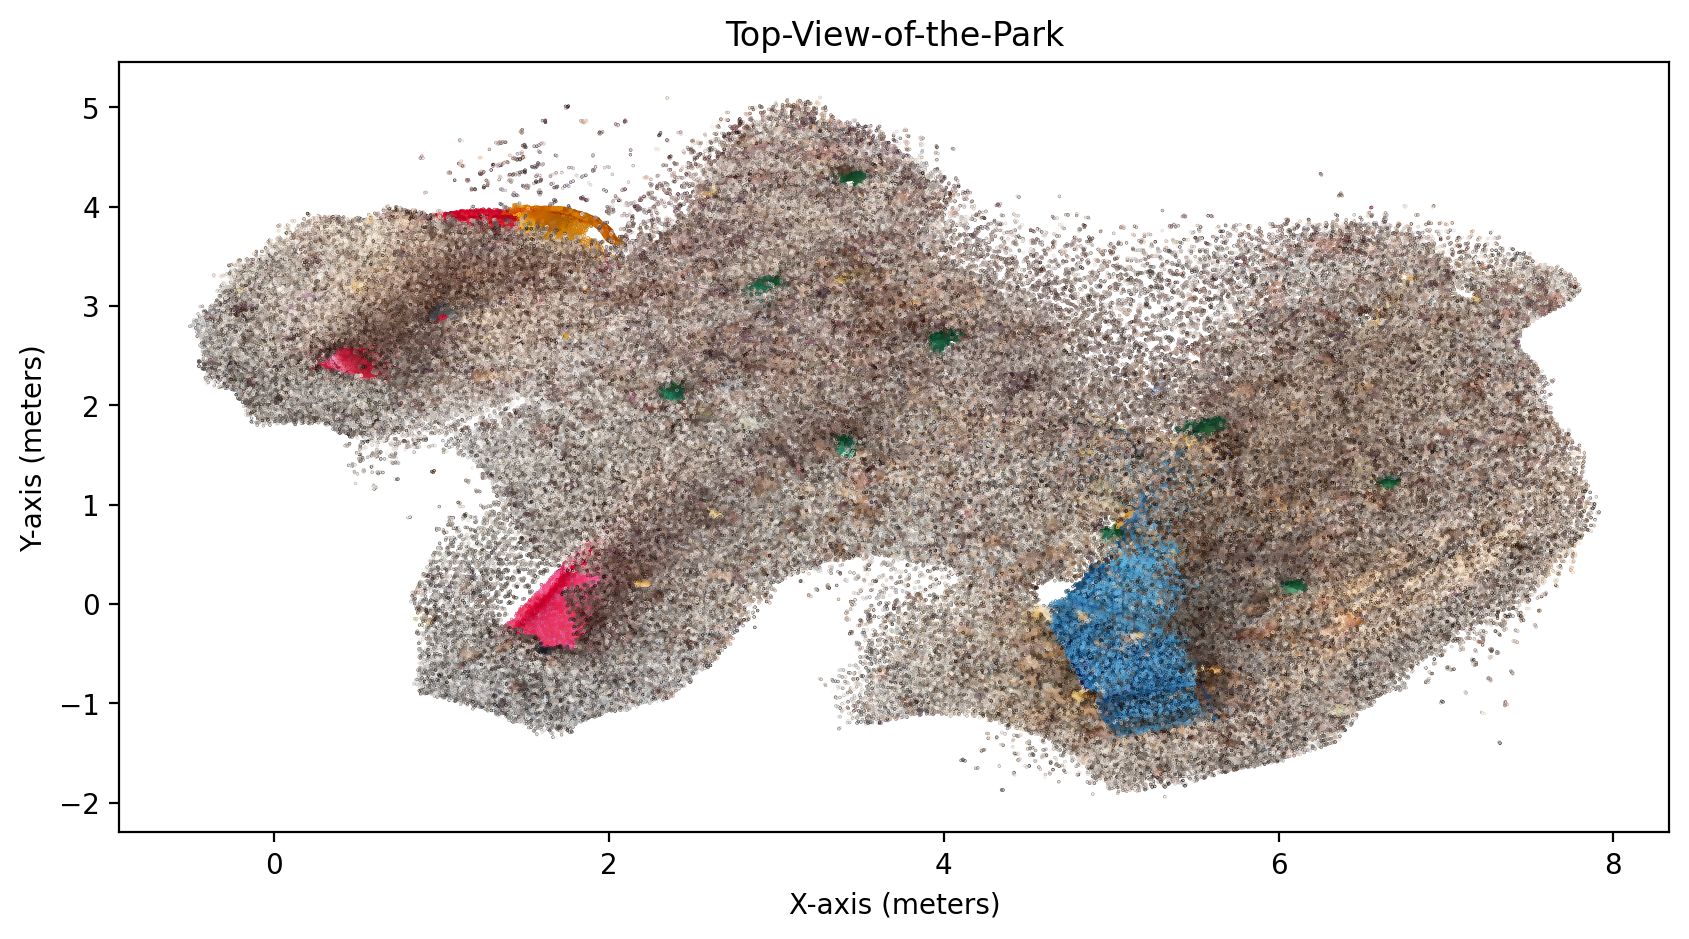

In [76]:
# Plot
plt.figure(figsize=(10, 5), dpi=200)
plt.scatter(xyz[:,0], xyz[:,1], c=rgb/255, s=0.05)
plt.title("Top-View-of-the-Park")
plt.xlabel('X-axis (meters)')
plt.ylabel('Y-axis (meters)')
plt.show()

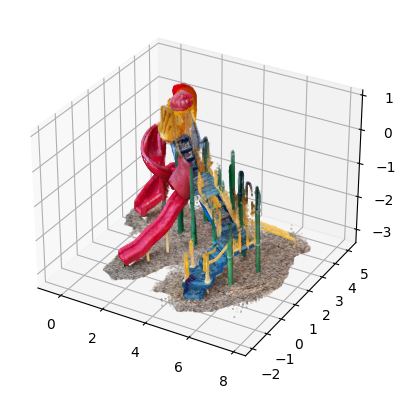

In [77]:
# 3d plotting
ax = plt.axes(projection='3d')
ax.scatter(xyz[:,0], xyz[:,1], xyz[:,2], c = rgb/255, s=0.01)
plt.show()

### 2. Automatic parameter Setup

In [78]:
# To find the K nearest neighbours
tree = KDTree(np.array(xyz), leaf_size=4)
nearest_dist, nearest_ind = tree.query(xyz, k=10)
mean_distance = np.mean(nearest_dist[:,1:])

In [79]:
# Nearest distances to the data
print("Nearest distances : \n", nearest_dist)

Nearest distances : 
 [[0.         0.01527051 0.01681333 ... 0.02553599 0.02896602 0.0299876 ]
 [0.         0.0111993  0.01257246 ... 0.01808749 0.01863623 0.01886698]
 [0.         0.01097384 0.0142921  ... 0.01838135 0.01839887 0.0184901 ]
 ...
 [0.         0.01378295 0.0166968  ... 0.02952378 0.02969757 0.03255559]
 [0.         0.01070698 0.01104667 ... 0.01981451 0.02109281 0.02840664]
 [0.         0.01313734 0.0134396  ... 0.02413872 0.02973877 0.03266857]]


In [80]:
# Mean distance to the data
print("Mean distance : ", mean_distance)

Mean distance :  0.018349693161751557


### 3. RANSAC Line fitting

a) Find a plane

In [81]:
# Finding the planes

inliers=[]
idx_samples = random.sample(range(len(xyz)), 3) # generating 3 random indexes
pt = xyz[idx_samples]   # Random sample of points

vector_A = pt[1] - pt[0]    # Vector A
vector_B = pt[2] - pt[0]    # Vector B
norm = np.cross(vector_A, vector_B) # Cross product of both the vectors A and B
a,b,c = norm / np.linalg.norm(norm) # plane ax+by+cz+d = 0 parameters a, b, c and d
d=-np.sum(norm*pt[1])   # The d parameter from the equation of the plane ax+by+cz+d = 0

In [82]:
print("Equation of the plane is ax + by + cz + d = 0")
print(f"Equation of the plane we get is : {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

Equation of the plane is ax + by + cz + d = 0
Equation of the plane we get is : 0.80x + 0.60y + -0.07z + -10.23 = 0


b) point to point distances by keeping thresholds

In [83]:
idx_inliers = []  # list of inliers indexes
dista = (
                   a * xyz[:,0] + b * xyz[:,1] + c * xyz[:,2] + d
            ) / np.sqrt(a ** 2 + b ** 2 + c ** 2) # Get the distance
thres=0.1   # Defining the threshold
idx_cand = np.where(np.abs(dista) <= thres)[0] # Check the distance if its less than the threshold and store its index in idx_cand

if len(idx_cand) > len(inliers):
  equation = [a,b,c,d]
  inliers = idx_cand    # get the inliers

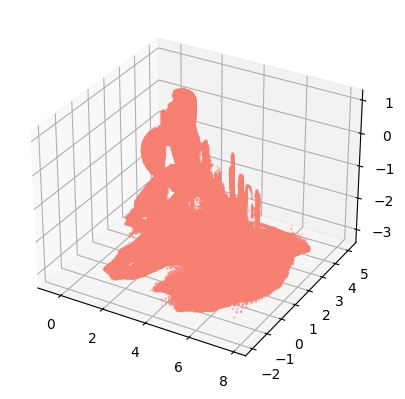

In [84]:
xyz_in=xyz[inliers] # Store the inliers

mask = np.ones(len(xyz), dtype=bool)
mask[inliers] = False

xyz_out=xyz[mask]   # Get the outliers

# 3D-point-cloud plotting
ax = plt.axes(projection='3d')
ax.scatter(xyz_in[:,0], xyz_in[:,1], xyz_in[:,2], c = 'cornflowerblue', s=0.02)
ax.scatter(xyz_out[:,0], xyz_out[:,1], xyz_out[:,2], c = 'salmon', s=0.02)
plt.show()

c) Iteration and function definition

In [85]:
# Function for ransac plane detection
def ransac_plane(xyz, thres=0.1, iterations=1500):
  inliers=[]
  n_points=len(xyz)
  i=1

  while i<iterations:
    idx_samples = random.sample(range(n_points), 3)
    pts = xyz[idx_samples]

    vecA = pts[1] - pts[0]
    vecB = pts[2] - pts[0]
    normal = np.cross(vecA, vecB)
    a,b,c = normal / np.linalg.norm(normal)
    d=-np.sum(normal*pts[1])

    dista = (
                       a * xyz[:,0] + b * xyz[:,1] + c * xyz[:,2] + d
                ) / np.sqrt(a ** 2 + b ** 2 + c ** 2)

    idx_cand = np.where(np.abs(dista) <= thres)[0]  # find the indexes at which the distanes is less than or equal to the threshold

    if len(idx_cand) > len(inliers):
      parameters = [a,b,c,d]    # store the line parameters
      inliers = idx_cand    # store the inliers

    i+=1
  return parameters, inliers    # return the line parameters and inliers

### 4. Point-cloud binary segmentation

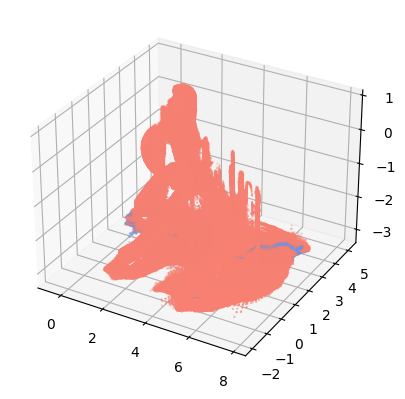

In [86]:
# Similarly we write the following

eq,idx_inliers=ransac_plane(xyz,0.02)   # get the indexes of the inliers
inliers=xyz[idx_inliers]    # get the inliers

mask = np.ones(len(xyz), dtype=bool)
mask[idx_inliers] = False

outliers=xyz[mask]  # Get the outliers

# 3D-Point cloud plotting
ax = plt.axes(projection='3d')
ax.scatter(inliers[:,0], inliers[:,1], inliers[:,2], c = 'cornflowerblue', s=0.02)
ax.scatter(outliers[:,0], outliers[:,1], outliers[:,2], c = 'salmon', s=0.02)
plt.show()

In [87]:
# Save the results in the ./RESULTS folder

result_folder="./RESULTS/"
np.savetxt(
    result_folder+path_to_file.split(".")[0]+"-inliers.xyz",
    inliers,
    fmt='%1.4f',
    delimiter=';'
)
np.savetxt(
    result_folder+path_to_file.split(".")[0]+"-outliers.xyz",
    outliers,
    fmt='%1.4f',
    delimiter=';'
)

### 5. Mark the object in the 3D point cloud (changing the object’s color), and estimate the distance to the object (the minimal depth)

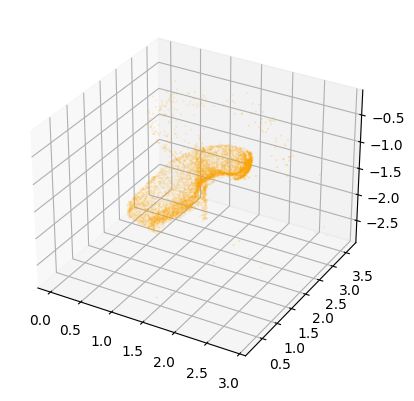

In [92]:
# Object plot

eq,idx_inliers=ransac_plane(xyz[1000:100000],0.02)   # get the indexes of the inliers
inliers=xyz[idx_inliers]    # get the inliers

mask = np.ones(len(xyz), dtype=bool)
mask[idx_inliers] = False

outliers=xyz[mask]  # Get the outliers

# 3D-Point cloud plotting
ax = plt.axes(projection='3d')
ax.scatter(inliers[:,0], inliers[:,1], inliers[:,2], c = 'orange', s=0.02)
#ax.scatter(outliers[:,0], outliers[:,1], outliers[:,2], c = 'salmon', s=0.02)
plt.show()

In [93]:
# To find the K nearest neighbours
tree = KDTree(np.array(xyz[1000:10000]), leaf_size=4)
nearest_dist, nearest_ind = tree.query(xyz, k=10)
mean_distance = np.mean(nearest_dist[:,1:])

In [94]:
# Nearest distances to the data
print("Nearest distances to the object (meters) : \n", nearest_dist)

Nearest distances to the object (meters) : 
 [[0.0299876  0.03236049 0.03570392 ... 0.03867931 0.0404899  0.0448513 ]
 [0.01257246 0.01751395 0.01863623 ... 0.0271825  0.02800336 0.03439433]
 [0.01839887 0.02131323 0.02416422 ... 0.02792754 0.02933092 0.02969177]
 ...
 [1.64582188 1.65524228 1.65530721 ... 1.66914319 1.67012136 1.67705038]
 [1.82589297 1.82978435 1.83277042 ... 1.84822134 1.8495997  1.85129539]
 [1.89319404 1.89656995 1.89987129 ... 1.91523901 1.91610465 1.91798897]]


In [95]:
# Mean distance to the data
print(f"Mean distance : {mean_distance:.2f} meters")

Mean distance : 2.53 meters


### 6. Conclusion

As we can see the object (Slider) in the park is detected and the mean distance is given as 2.53 meters